Homework 3 - CNN

# **Importing Important Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
from torchsummary import summary

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

### If the GPU is available use it for the computation otherwise use the CPU.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Downloading and loading MNIST Fashion dataset

In [3]:
train_set = torchvision.datasets.FashionMNIST("hw/fashionmnist",  download=True,transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("hw/fashionmnist", download=True,train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  

Extracting hw/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to hw/fashionmnist/FashionMNIST/raw


Extracting hw/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to hw/fashionmnist/FashionMNIST/raw


Extracting hw/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to hw/fashionmnist/FashionMNIST/raw


Extracting hw/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to hw/fashionmnist/FashionMNIST/raw
Processing...
Done!





/Users/captainbeetal/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Creating train and test loader using torch DataLoader clas with batch size of 100

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=100)

In [8]:
for x,y in train_loader:
    print(y)
    break

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8])


### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

## Important User Defined Functions

> 
Below function trains a model on the number of epoch as passed in the function parameter. We are using Cross entropy as the loss function for all the predictions and Adam as the optimizer.


In [32]:
error = nn.CrossEntropyLoss()

learning_rate = 0.001


def training(epoch,model,train_loader,val_loader):
    num_epochs = epoch
    train_lss = []
    val_loss = []
    accuracy_list = []
    count=0
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)

            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels)
            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()
            #Propagating the error backward
            loss.backward()
            # Optimizing the parameters
            optimizer.step()
            count += 1
            
            train_lss.append(loss.item())
        
        with torch.no_grad():
            # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                test = Variable(images.view(100, 1, 28, 28))

                outputs = model(test)
                val_lss = error(outputs, labels)
                
                predictions = torch.max(outputs, 1)[1].to(device)
                correct += (predictions == labels).sum()
                total += len(labels)
                val_loss.append(val_lss.item())
                
            accuracy = correct * 100 // total
            accuracy_list.append(accuracy)
            
                
        
        print("Epoch: %d, training loss: %1.5f , validation loss: %1.5f , validation accuracy: %1.5f" 
              % (epoch, loss.item(),val_lss.item(),accuracy))

    return train_lss,val_loss,accuracy_list

> Below function plots the training and validation loss which is returned by our training function above.


In [52]:
def plot_TrainTestMSE(epoch,train_loss,test_loss):
    
    blue_patch = mpatches.Patch(color='blue', label='Train MSE')
    green_patch = mpatches.Patch(color='orange', label='Validation MSE')
    
    #Using matplotlib subplot to create two subplot and specifying figure size as 14x6
    plt.figure(figsize=(14,6))
    
    #plotting the first plot
    #plotting the train loss
    sns.lineplot(x=range(1,epoch+1),y=train_loss)
    #plotting the testing loss
    sns.lineplot(x=range(1,epoch+1),y=test_loss)
    #specifying the title for first plot

    sns.despine(top=True)
    
    #specifying the super title for both the plot
    plt.suptitle("Training and Validation loss");

## Building a CNN 

### CNN Model 1 with one 2d conv layer followed by two linear layer

We have used a 2d-conv layer with kernel-size as 3 and padding 1. The conv layer is followed by batch normalization layer, relu activation function and finally a max pool 2d layer. The output of the this layer is fed into two linear layer.

In [17]:
class FashionCNN1(nn.Module):
    def __init__(self):
        super(FashionCNN1, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=32*14*14, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc3(out)
        
        return out

In [33]:
model1 = FashionCNN1()
model1.to(device)

FashionCNN1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [75]:
summary(model1,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 120]         752,760
            Linear-6                   [-1, 10]           1,210
Total params: 754,354
Trainable params: 754,354
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.62
Params size (MB): 2.88
Estimated Total Size (MB): 3.50
----------------------------------------------------------------


```
Above is the model summary with the computation resources required. For one image it need 2.88 mb size for the parameters and the 3.5 mb total size. It has total 754354 parameters.
```

In [34]:
train_lss,val_loss,accuracy_list = training(10,model1,train_loader,test_loader)

Epoch: 0, training loss: 0.31577 , validation loss: 0.30871 , validation accuracy: 89.00000
Epoch: 1, training loss: 0.28794 , validation loss: 0.27418 , validation accuracy: 90.00000
Epoch: 2, training loss: 0.27084 , validation loss: 0.25642 , validation accuracy: 91.00000
Epoch: 3, training loss: 0.25598 , validation loss: 0.23626 , validation accuracy: 91.00000
Epoch: 4, training loss: 0.22499 , validation loss: 0.21591 , validation accuracy: 92.00000
Epoch: 5, training loss: 0.21984 , validation loss: 0.20035 , validation accuracy: 92.00000
Epoch: 6, training loss: 0.17286 , validation loss: 0.16321 , validation accuracy: 93.00000
Epoch: 7, training loss: 0.14689 , validation loss: 0.13185 , validation accuracy: 94.00000
Epoch: 8, training loss: 0.13147 , validation loss: 0.11401 , validation accuracy: 94.00000
Epoch: 9, training loss: 0.14623 , validation loss: 0.12364 , validation accuracy: 93.00000


```
We have trained our model for 10 epoch. Since we are using batch of size 100 and our train dataset has 60,000 images, we have total 600 iteration per epoch which gives us total of 6000 iterations for 10 epoch. And that is why we are only training model with 10 epochs. 

With the 10 epoch and 1 2d-conv layer, we are managed to acheived 94% best validation accuracy. Also, from the training loss and validation loss, we can observe that the model was training very well. Since both the losses are decreasing per epoch.
```

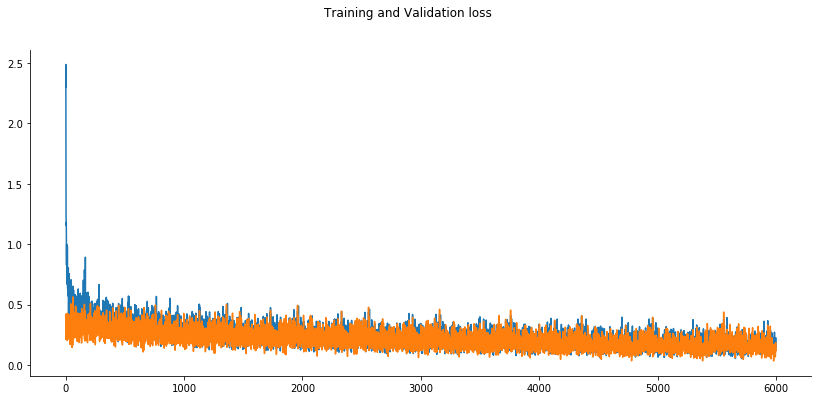

In [53]:
plot_TrainTestMSE(6000,train_lss,val_loss)

> The above plot is ploted between the total iterations and validation/training loss. In the above cell I had explained how we have 6000 iteration in 10 epoch. From the it seems that both the loses have various ups and downs but we must keep in mind that these losses are per iteration not per epoch. We got decreasing losses per epoch as in the output in previous cell. 

### CNN Model 2 with two 2d conv layer, one dropout layer followed by three linear layer

We have used two 2d-conv layer. The conv layer is followed by batch normalization layer, relu activation function and finally a max pool 2d layer in each layer. The output of the second conv layer is fed into a linear layer then a dropout layer and finally two more linear layer.

In [62]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out


In [66]:
model3 = FashionCNN()
model3.to(device)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [82]:
summary(model3,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

```
Above is the model summary with the computation resources required. For one image it need 5.63 mb size for the parameters and the 6.49 mb total size. Our this model consumes almost twice the memory than the previous model. Also, it has total 1,475,338 parameters which are also almost twice than the previous model. This model will take more time in computation, almost double the time and also requires more resources
```

In [67]:
train_lss,val_loss,accuracy_list = training(10,model3,train_loader,test_loader)

Epoch: 0, training loss: 0.41340 , validation loss: 0.39321 , validation accuracy: 86.00000
Epoch: 1, training loss: 0.30660 , validation loss: 0.32747 , validation accuracy: 91.00000
Epoch: 2, training loss: 0.24516 , validation loss: 0.24092 , validation accuracy: 92.00000
Epoch: 3, training loss: 0.22223 , validation loss: 0.20712 , validation accuracy: 93.00000
Epoch: 4, training loss: 0.28427 , validation loss: 0.21948 , validation accuracy: 93.00000
Epoch: 5, training loss: 0.19040 , validation loss: 0.16131 , validation accuracy: 94.00000
Epoch: 6, training loss: 0.16154 , validation loss: 0.14288 , validation accuracy: 94.00000
Epoch: 7, training loss: 0.16845 , validation loss: 0.13849 , validation accuracy: 94.00000
Epoch: 8, training loss: 0.18552 , validation loss: 0.14878 , validation accuracy: 95.00000
Epoch: 9, training loss: 0.17062 , validation loss: 0.13146 , validation accuracy: 94.00000


```
We have trained our model for 10 epoch. Since we are using batch of size 100 and our train dataset has 60,000 images, we have total 600 iteration per epoch which gives us total of 6000 iterations for 10 epoch. And that is why we are only training model with 10 epochs. 

With the 10 epoch and 2 2d-conv layer, we are managed to acheived 95% best validation accuracy. Also, from the training loss and validation loss, we can observe that the model was training very well. Since both the losses are decreasing per epoch.
```

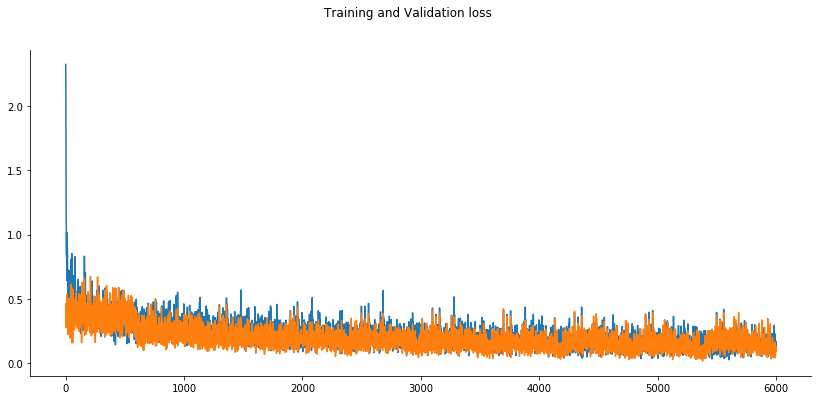

In [79]:
plot_TrainTestMSE(6000,train_lss,val_loss)

> The above plot is ploted between the total iterations and validation/training loss. In the above cell I had explained how we have 6000 iteration in 10 epoch. From the it seems that both the loses have various ups and downs but we must keep in mind that these losses are per iteration not per epoch. We got decreasing losses per epoch as in the output in previous cell. 

### Conclusion

```
Our second model has performed better than the first model in terms of accuracy. But if we compare in terms of computation resources required and time it takes to train the model, our model gives the best result. Consuming almost twice the resources and twice the time to train the model, we are managed to increase the accuracy by only 1% which is not a good tradeoff between accuracy and computation resources required.

```

### References

> https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

> All the function used in this are copied from previous assignmnet HW2

> https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

> https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm2d#torch.nn.BatchNorm2d

> https://www.kaggle.com/tinydman/fashion-mnist-with-pytorch

> https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout

> https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d

> https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear